# **Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression**

**Tujuan**: Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression, lalu menerapkan threshold untuk klasifikasi status

**Lokasi** Mencangkup :
- Kota Surabaya
- Sebagian wilayah Kabupaten Sidoarjo
- Sebagian Kabupaten Gresik

**Data Source**: Sentinel-5P (Copernicus Data Space)

**Metode**:
- KNN Regression untuk prediksi nilai kontinyu
- Threshold Application untuk klasifikasi (Aman/Berbahaya)

**Periode**:
- During COVID: **2020-06-01 s.d. 2021-06-30**
- Post COVID: **2022-06-01 s.d. 2023-06-30**

## **1. Mengumpulkan data dan dijadikan CSV**

In [3]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

spatial_extent = {
    "west": 112.5,
    "south": -7.45,
    "east": 112.95,
    "north": -7.05
}

# During COVID
s5covid = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2020-06-01", "2021-06-30"],
    spatial_extent=spatial_extent,
    bands=["NO2"], 
).aggregate_temporal_period(reducer="mean", period="day")

# Post COVID
s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-06-01", "2023-06-30"],
    spatial_extent=spatial_extent,
    bands=["NO2"],  
).aggregate_temporal_period(reducer="mean", period="day")

job_covid = s5covid.execute_batch(title="NO2 during Covid", outputfile="during_covid.nc")
job_post = s5post.execute_batch(title="NO2 Post-Covid", outputfile="post_covid.nc")

Authenticated using refresh token.
0:00:00 Job 'j-25102415254144aaa53e7143b5cdf76c': send 'start'
0:00:14 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:19 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:26 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:34 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:00:44 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:00:57 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:13 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:32 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:56 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:02:27 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:03:06 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:03:53 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:04:52 Job 'j-25102415254144

In [5]:
# --- DOWNLOAD HASIL DARI SERVER ---
results_covid = job_covid.get_results()
results_post = job_post.get_results()

results_covid.download_files(target="results_covid")
results_post.download_files(target="results_post")

# --- KONVERSI KE CSV ---
import xarray as xr
import pandas as pd

# Load data dari NetCDF
during = xr.open_dataset("during_covid.nc")
post = xr.open_dataset("post_covid.nc")

# Ambil rata-rata spasial (x dan y) biar jadi satu nilai NO2 per waktu
during_mean = during.NO2.mean(dim=["x", "y"]).to_dataframe().reset_index()
post_mean = post.NO2.mean(dim=["x", "y"]).to_dataframe().reset_index()

# Simpan hasil ke CSV
during_mean.to_csv("no2_during_covid.csv", index=False)
post_mean.to_csv("no2_post_covid.csv", index=False)

print("✅ Data berhasil disimpan sebagai CSV:")
print("- no2_during_covid.csv")
print("- no2_post_covid.csv")

✅ Data berhasil disimpan sebagai CSV:
- no2_during_covid.csv
- no2_post_covid.csv


## **2. Memprosessing data jika ada missing values  dengan interpolasi**
Mengisi missing values dengan interpolasi waktu (time-based interpolation) agar datanya tetap konsisten untuk analisis.

In [14]:
import pandas as pd

# Load data hasil tahap 1
during_mean = pd.read_csv("no2_during_covid.csv")
post_mean = pd.read_csv("no2_post_covid.csv")

print("📊 HASIL PEMROSESAN DATA NO₂\n")

# 🔍 Cek missing values sebelum interpolasi
missing_during_before = during_mean.isna().sum()
missing_post_before = post_mean.isna().sum()

print("🔍 Missing Values Sebelum Interpolasi:")
print(f"- During COVID:\n{missing_during_before}")
print(f"- Post COVID:\n{missing_post_before}\n")

# --- Pastikan kolom waktu dikenali sebagai datetime dan dijadikan index ---
for df in [during_mean, post_mean]:
    if 't' in df.columns:  # kalau nama kolom waktu 't'
        df.rename(columns={'t': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

# --- Interpolasi time-based ---
during_mean_interpolated = during_mean.interpolate(method='time')
post_mean_interpolated = post_mean.interpolate(method='time')

# Cek hasil interpolasi
missing_during_after = during_mean_interpolated.isna().sum()
missing_post_after = post_mean_interpolated.isna().sum()

print("✅ Missing Values Setelah Interpolasi:")
print(f"- During COVID:\n{missing_during_after}")
print(f"- Post COVID:\n{missing_post_after}\n")

#  Simpan hasil interpolasi ke CSV baru
during_mean_interpolated.reset_index().to_csv("no2_during_covid_clean.csv", index=False)
post_mean_interpolated.reset_index().to_csv("no2_post_covid_clean.csv", index=False)

print("💾 Data bersih sudah disimpan sebagai:")
print("- no2_during_covid_clean.csv")
print("- no2_post_covid_clean.csv\n")

# --- Buat ringkasan tabel hasil pembersihan data ---
summary = pd.DataFrame({
    "Dataset": ["During COVID", "Post COVID"],
    "Missing Sebelum": [missing_during_before['NO2'], missing_post_before['NO2']],
    "Missing Setelah": [missing_during_after['NO2'], missing_post_after['NO2']],
})

print("📋 Ringkasan Proses Interpolasi:\n")
display(summary)


📊 HASIL PEMROSESAN DATA NO₂

🔍 Missing Values Sebelum Interpolasi:
- During COVID:
t       0
NO2    78
dtype: int64
- Post COVID:
t       0
NO2    85
dtype: int64

✅ Missing Values Setelah Interpolasi:
- During COVID:
NO2    2
dtype: int64
- Post COVID:
NO2    0
dtype: int64

💾 Data bersih sudah disimpan sebagai:
- no2_during_covid_clean.csv
- no2_post_covid_clean.csv

📋 Ringkasan Proses Interpolasi:



,Dataset,Missing Sebelum,Missing Setelah
0,During COVID,78,2
1,Post COVID,85,0


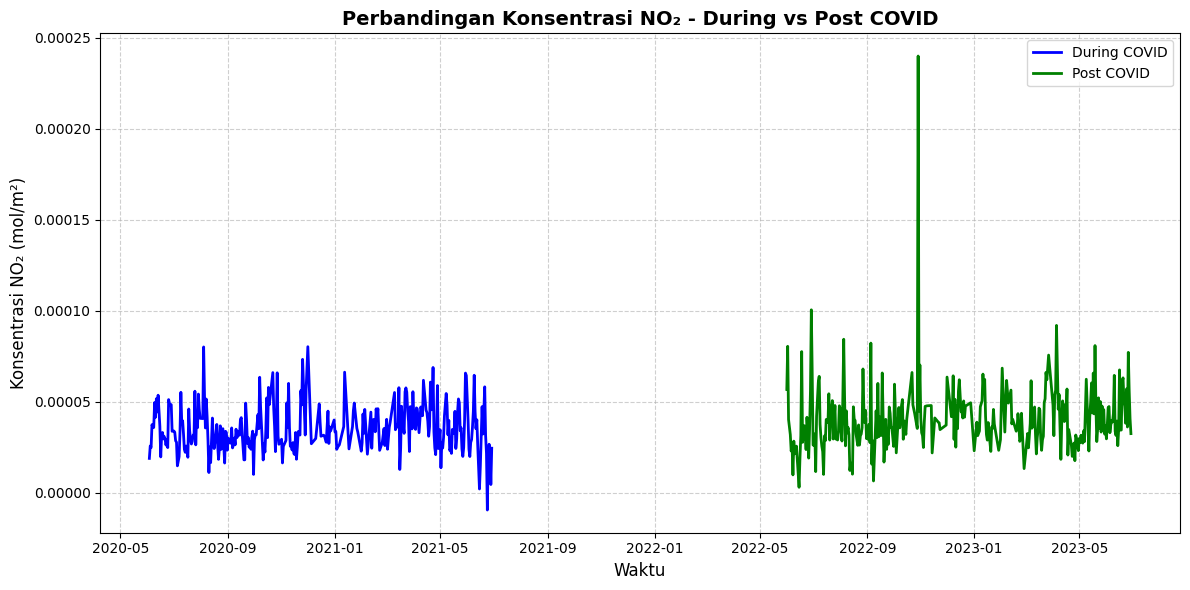

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data bersih ---
during = pd.read_csv("no2_during_covid_clean.csv")
post = pd.read_csv("no2_post_covid_clean.csv")

# Pastikan kolom waktu terdeteksi sebagai datetime
during['time'] = pd.to_datetime(during['time'])
post['time'] = pd.to_datetime(post['time'])

# --- Buat plot ---
plt.figure(figsize=(12, 6))
plt.plot(during['time'], during['NO2'], label='During COVID', color='blue', linewidth=2)
plt.plot(post['time'], post['NO2'], label='Post COVID', color='green', linewidth=2)

# --- Tambahan estetika ---
plt.title('Perbandingan Konsentrasi NO₂ - During vs Post COVID', fontsize=14, weight='bold')
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Konsentrasi NO₂ (mol/m²)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Tampilkan plot ---
plt.show()


### **Penjelasan:** 
**Perbandingan Konsentrasi NO₂ - During vs Post COVID**
- **Sumbu-X (horizontal)**: Waktu pengamatan (dalam rentang tanggal).
- **Sumbu-Y (vertikal)**: Konsentrasi NO₂ (Nitrogen Dioksida) dalam satuan mol/m².

 **Periode During COVID (garis biru) :**
- Terlihat relatif stabil dengan sedikit fluktuasi di kisaran 0.00003–0.00007 mol/m².
- Tidak ada lonjakan besar — ini menunjukkan bahwa selama pandemi (saat mobilitas menurun), polusi NO₂ cenderung rendah dan terkendali.
- Hal ini sesuai dengan banyak penelitian yang menemukan penurunan emisi akibat pembatasan aktivitas industri dan transportasi.

 **Periode Post COVID (garis hijau) :**
- Secara umum, tingkat NO₂ meningkat sedikit dibanding masa pandemi.
- Ada satu lonjakan signifikan sekitar pertengahan 2022, kemungkinan besar akibat aktivitas industri/transportasi yang kembali normal.
- Setelah lonjakan itu, pola NO₂ cenderung lebih fluktuatif, menunjukkan aktivitas ekonomi yang sudah pulih.

 **Kesimpulan dari Grafik :**
- Secara visual, **selama pandemi** terjadi **penurunan konsentrasi NO₂** yang cukup konsisten.
- **Setelah pandemi**, terjadi **kenaikan dan variabilitas lebih besar**. Artinya aktivitas emisi kembali meningkat.
- Grafik ini mendukung analisis dampak kebijakan pembatasan sosial terhadap kualitas udara.

## **3. Membentuk Data Supervised**
Mengubah data deret waktu (time series) menjadi data supervised learning, yaitu dengan membuat pasangan:
- Input (X): nilai NO₂ pada waktu sebelumnya
- Target (y): nilai NO₂ pada waktu berikutnya

In [16]:
import pandas as pd

# --- Load data bersih hasil interpolasi ---
during_clean = pd.read_csv("no2_during_covid_clean.csv")
post_clean = pd.read_csv("no2_post_covid_clean.csv")

# Pastikan kolom waktu diubah jadi datetime
during_clean['time'] = pd.to_datetime(during_clean['time'])
post_clean['time'] = pd.to_datetime(post_clean['time'])

# --- Fungsi bantu untuk ubah time series ke supervised ---
def make_supervised(df, target_col='NO2', lag=1):
    data = pd.DataFrame()
    for i in range(1, lag + 1):
        data[f'{target_col}_lag{i}'] = df[target_col].shift(i)
    data[target_col] = df[target_col]
    data = data.dropna().reset_index(drop=True)
    return data

# Ubah data menjadi format supervised dengan 1 lag (bisa diganti ke 2–3 lag kalau mau)
during_supervised = make_supervised(during_clean)
post_supervised = make_supervised(post_clean)

# --- Simpan hasil ke CSV ---
during_supervised.to_csv("no2_during_covid_supervised.csv", index=False)
post_supervised.to_csv("no2_post_covid_supervised.csv", index=False)

print("✅ Data supervised berhasil dibuat dan disimpan:")
print("- no2_during_covid_supervised.csv")
print("- no2_post_covid_supervised.csv")

# --- Tampilkan contoh data ---
print("\n📋 Contoh data supervised (During COVID):")
display(during_supervised.head())



✅ Data supervised berhasil dibuat dan disimpan:
- no2_during_covid_supervised.csv
- no2_post_covid_supervised.csv

📋 Contoh data supervised (During COVID):


,NO2_lag1,NO2
0,0.000019,0.000026
1,0.000026,0.000025
2,0.000025,0.000037
3,0.000037,0.000036
4,0.000036,0.000036


### **Penjelasan :**
- Kolom NO2_lag1 → nilai NO₂ pada waktu sebelumnya (t-1)
- Kolom NO2 → nilai NO₂ pada waktu sekarang (t)
- Setiap baris menunjukkan pasangan data yang bisa digunakan untuk prediksi deret waktu (time series) — misalnya memprediksi kadar NO₂ berdasarkan data sebelumnya.

## **4. Melakukan normalisai data (min-max atau zscore (standar scale di sklearn))**
- Min-Max Scaling: ubah data ke rentang [0, 1]
- Menggabungkan **no2_during_covid_supervised.csv** dan **no2_post_covid_supervised.csv** jadi satu dataset berurutan waktu **no2_all_supervised.csv**

In [23]:
# --- GABUNGKAN DAN NORMALISASI DATA (DURING + POST) ---
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. Load data supervised dari kedua periode ---
during_supervised = pd.read_csv("no2_during_covid_supervised.csv")
post_supervised = pd.read_csv("no2_post_covid_supervised.csv")

# Gabungkan data jadi satu dataframe
df_all = pd.concat([during_supervised, post_supervised], ignore_index=True)

# Simpan versi mentah (belum dinormalisasi)
df_all.to_csv("no2_all_supervised.csv", index=False)
print("✅ Data during + post digabung → no2_all_supervised.csv")

# --- 2. Pisahkan fitur (X) dan target (y) ---
X = df_all.drop(columns=["NO2"])
y = df_all[["NO2"]]

# --- 3. Split data manual: 80% train, 20% test (berdasarkan urutan waktu) ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 4. Normalisasi hanya berdasarkan data TRAIN ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit hanya di train
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform test menggunakan scaler dari train
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# --- 5. Simpan hasil ke file CSV ---
train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
train_scaled["NO2"] = y_train_scaled

test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
test_scaled["NO2"] = y_test_scaled

train_scaled.to_csv("no2_all_train_scaled.csv", index=False)
test_scaled.to_csv("no2_all_test_scaled.csv", index=False)

print("✅ Normalisasi berhasil dilakukan (fit di train, transform di test)")
print("📁 File tersimpan sebagai:")
print(" - no2_all_train_scaled.csv")
print(" - no2_all_test_scaled.csv")

✅ Data during + post digabung → no2_all_supervised.csv
✅ Normalisasi berhasil dilakukan (fit di train, transform di test)
📁 File tersimpan sebagai:
 - no2_all_train_scaled.csv
 - no2_all_test_scaled.csv


### **Model gradient boosting (lebih kuat dari RF)**
Model seperti XGBoost umumnya lebih baik dalam:
- menangani data time series regresi non-linear,
- menurunkan error (MAPE),
- memperbaiki autokorelasi residu.

In [24]:
# --- 1. Import library utama ---
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 2. Baca dataset ---
# Gantilah nama file sesuai yang kamu punya
df = pd.read_csv('no2_all_supervised.csv')

# Pastikan ada kolom target, misal 'NO2'
print("Kolom data:", df.columns.tolist())

# Jika kolom target bernama lain, ubah di sini:
target_col = 'NO2'

# --- 3. Pisahkan fitur dan target ---
X = df.drop(columns=[target_col])
y = df[target_col]

# Pastikan keduanya punya bentuk 2D dan 1D yang benar
print("X shape:", X.shape)
print("y shape:", y.shape)

# --- 4. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

# --- 5. Buat dan latih model XGBoost ---
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Tambahan: pastikan X_train tidak kosong
assert not X_train.empty, "❌ X_train kosong, pastikan dataset memiliki cukup data!"
assert len(X_train.shape) == 2, "❌ X_train harus 2D (baris, kolom)!"

xgb.fit(X_train, y_train)

# --- 6. Evaluasi ---
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\n📊 Hasil Evaluasi XGBoost:")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.3f}")
print(f"MAPE : {mape:.2f}%")

Kolom data: ['NO2_lag1', 'NO2']
X shape: (778, 1)
y shape: (778,)

📊 Hasil Evaluasi XGBoost:
MSE  : 0.0000
R²   : -0.080
MAPE : 28.31%


### **Penjelasan :**

1. **File no2_during_covid_train_scaled.csv berisi**:
- Data training yang sudah dinormalisasi ke rentang [0, 1].
- Kolom:
    - NO2_lag1_scaled → nilai NO₂ hari sebelumnya yang sudah dinormalisasi.
    - NO2_scaled → nilai NO₂ hari ini yang sudah dinormalisasi.

2. **File no2_during_covid_test_scaled.csv berisi**:
- Data testing yang juga sudah diubah ke skala yang sama dengan training.
- Struktur kolomnya sama seperti file train

## **5. Membuat model dengan K-NN regression**
- Melakukan experiment dengan beberapa fitur (menentukan berapa lag data : berkaitan dengan no 3)



📊 HASIL EVALUASI KNN (Lag = 1)
🔹 MSE  : 0.003208
🔹 R²   : 0.0353
🔹 MAPE : 21.89%


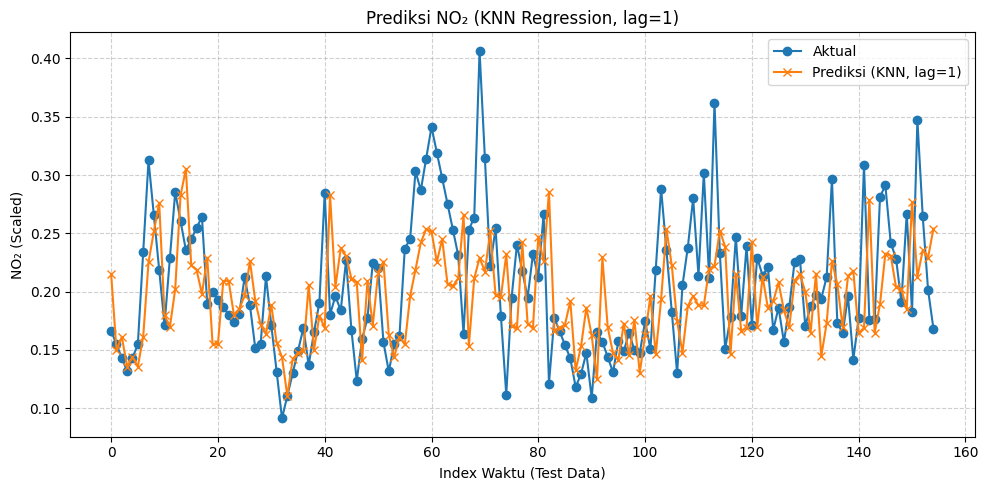


📊 HASIL EVALUASI KNN (Lag = 2)
🔹 MSE  : 0.003398
🔹 R²   : -0.0181
🔹 MAPE : 22.69%


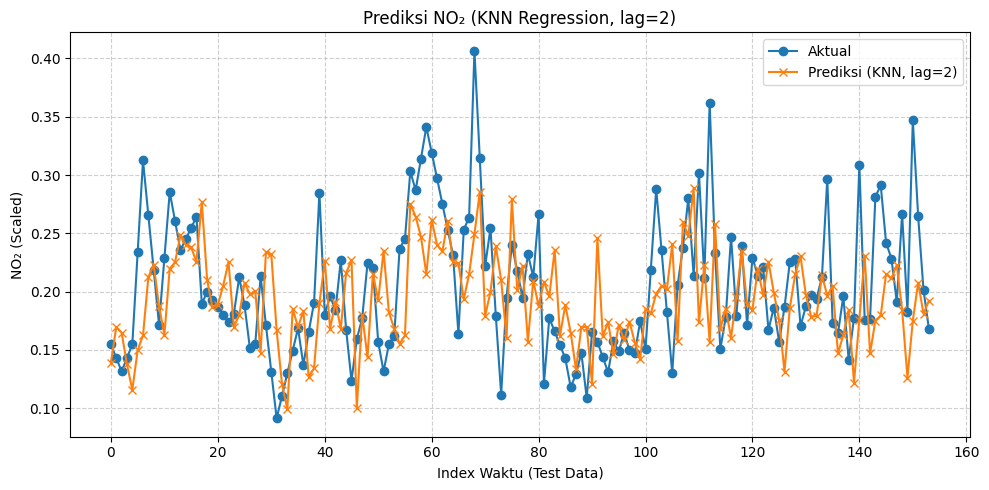


📊 HASIL EVALUASI KNN (Lag = 3)
🔹 MSE  : 0.003338
🔹 R²   : 0.0017
🔹 MAPE : 20.39%


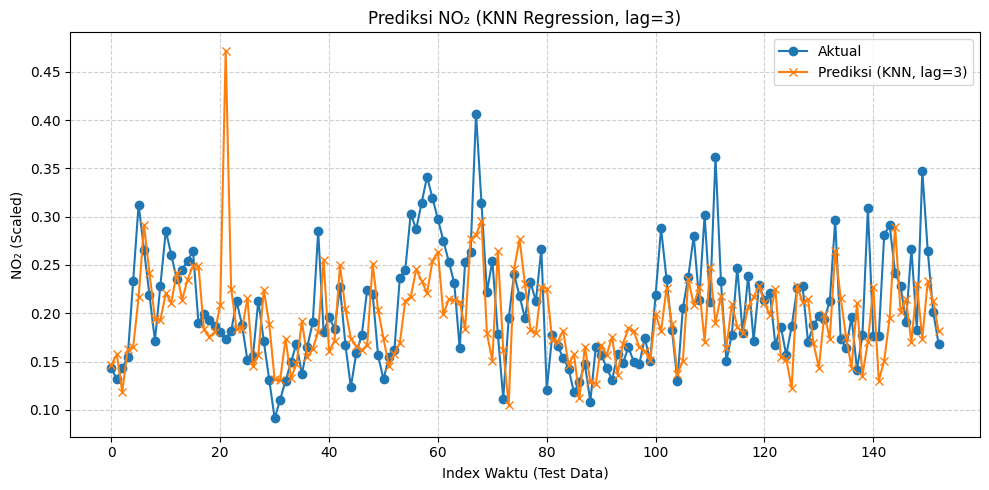


📊 HASIL EVALUASI KNN (Lag = 4)
🔹 MSE  : 0.003183
🔹 R²   : 0.0471
🔹 MAPE : 20.29%


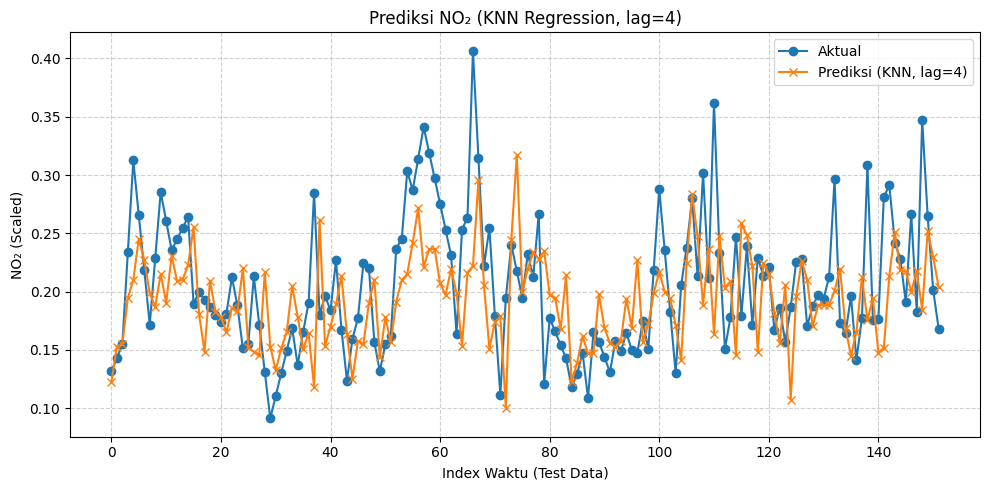


📊 HASIL EVALUASI KNN (Lag = 5)
🔹 MSE  : 0.003224
🔹 R²   : 0.0309
🔹 MAPE : 21.46%


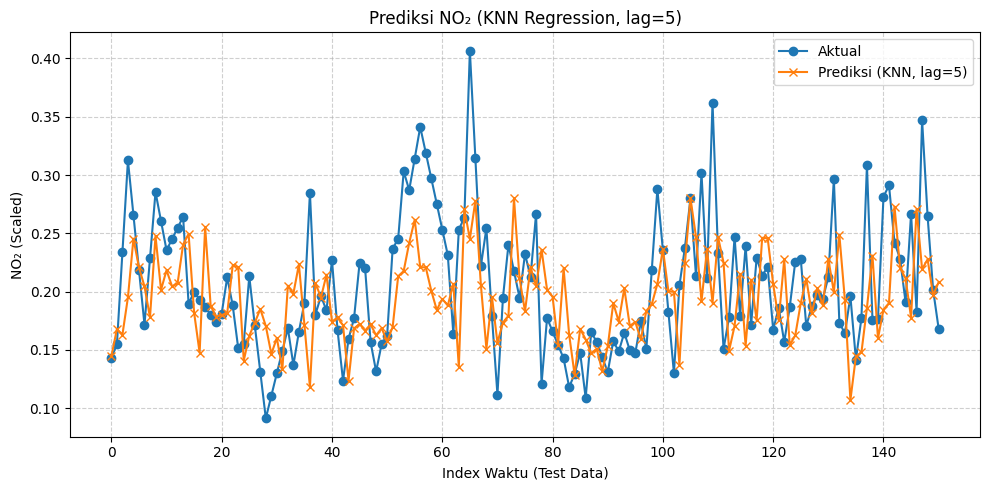


📊 HASIL EVALUASI KNN (Lag = 6)
🔹 MSE  : 0.003876
🔹 R²   : -0.1664
🔹 MAPE : 22.33%


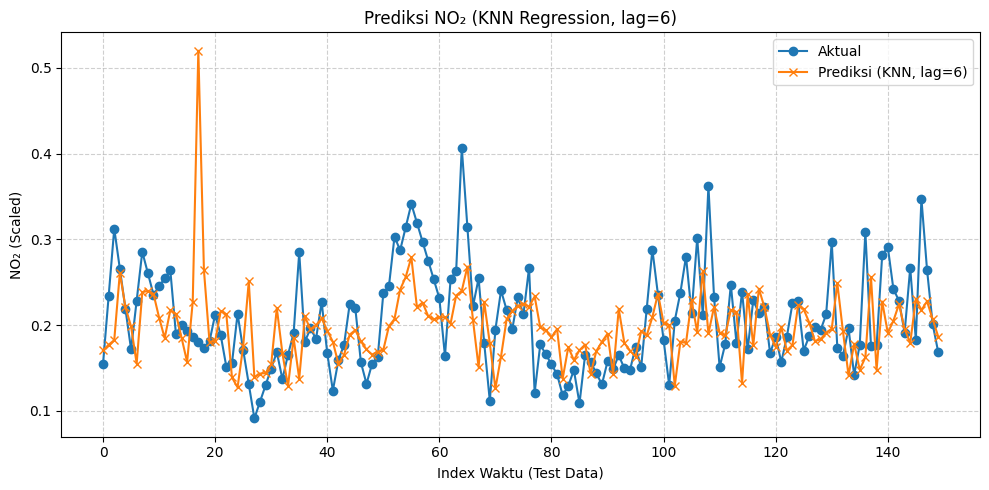


📊 HASIL EVALUASI KNN (Lag = 7)
🔹 MSE  : 0.004004
🔹 R²   : -0.2031
🔹 MAPE : 23.41%


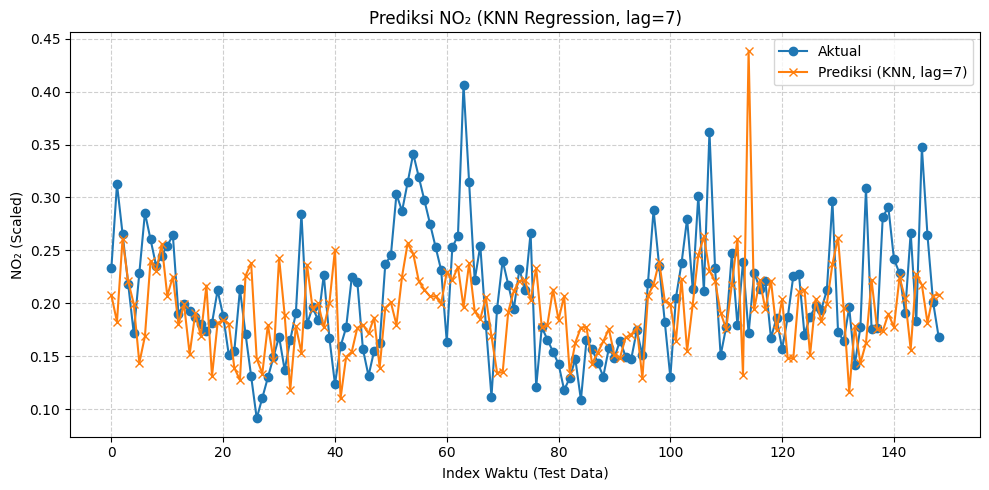


📈 Rangkuman Hasil Evaluasi KNN Regression:
   lag       MSE        R2       MAPE
0    1  0.003208  0.035318  21.891401
1    2  0.003398 -0.018146  22.689767
2    3  0.003338  0.001671  20.388410
3    4  0.003183  0.047056  20.287565
4    5  0.003224  0.030933  21.460059
5    6  0.003876 -0.166370  22.327710
6    7  0.004004 -0.203116  23.407815


In [25]:
# --- Evaluasi KNN Regression dengan Lag 1–7 ---
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- 1. Load Data Normalisasi ---
train = pd.read_csv("no2_all_train_scaled.csv")
test = pd.read_csv("no2_all_test_scaled.csv")

# --- 2. Fungsi Membuat Lag Dataset ---
def make_lagged(df, target_col='NO2', lag=1):
    data = pd.DataFrame()
    for i in range(1, lag + 1):
        data[f'{target_col}_lag{i}'] = df[target_col].shift(i)
    data[target_col] = df[target_col]
    data = data.dropna().reset_index(drop=True)
    return data

# --- 3. Fungsi Evaluasi Model KNN ---
def evaluate_knn_for_lag(lag):
    train_lagged = make_lagged(train, lag=lag)
    test_lagged = make_lagged(test, lag=lag)

    X_train = train_lagged.drop(columns=['NO2'])
    y_train = train_lagged['NO2']
    X_test = test_lagged.drop(columns=['NO2'])
    y_test = test_lagged['NO2']

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    print(f"\n📊 HASIL EVALUASI KNN (Lag = {lag})")
    print(f"🔹 MSE  : {mse:.6f}")
    print(f"🔹 R²   : {r2:.4f}")
    print(f"🔹 MAPE : {mape:.2f}%")

    # Visualisasi
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label="Aktual", marker='o')
    plt.plot(y_pred, label=f"Prediksi (KNN, lag={lag})", marker='x')
    plt.title(f"Prediksi NO₂ (KNN Regression, lag={lag})")
    plt.xlabel("Index Waktu (Test Data)")
    plt.ylabel("NO₂ (Scaled)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return {"lag": lag, "MSE": mse, "R2": r2, "MAPE": mape}

# --- 4. Jalankan Evaluasi untuk Lag 1–7 ---
results = [evaluate_knn_for_lag(lag) for lag in range(1, 8)]

# --- 5. Rekapitulasi Hasil Evaluasi ---
results_df = pd.DataFrame(results)
print("\n📈 Rangkuman Hasil Evaluasi KNN Regression:")
print(results_df)

### **Penjelasan :**
- mean_absolute_percentage_error() menghitung rata-rata kesalahan prediksi dalam persentase terhadap nilai aktual.
- MAPE memberikan interpretasi intuitif seperti:
    - <10% → Akurat
    - 10–20% → Cukup baik
    - 20–50% → Kurang akurat
    - 50% → Buruk

**Intrepertasi Grafik :**
- Grafik per lag menunjukkan jarak antara garis aktual dan prediksi.
- Pada lag 1–2, model gagal menangkap fluktuasi tajam NO₂ (prediksi cenderung rata).
- Lag 4 menampilkan pola yang lebih sinkron — puncak dan lembah prediksi lebih sejajar dengan nilai aktual.
- Lag >5, prediksi mulai melenceng dan kehilangan pola temporal.
- Nilai MSE (Mean Squared Error) relatif stabil di sekitar 0.003–0.004, artinya tingkat kesalahan model tidak banyak berubah antar lag.
- R² menunjukkan seberapa besar variasi data yang bisa dijelaskan model (semakin mendekati 1 → semakin baik).
    - Terbaik pada lag 4 (R² = 0.047) → artinya model paling mampu mengikuti pola aktual saat melihat data 4 hari sebelumnya.
- MAPE (Mean Absolute Percentage Error) menunjukkan rata-rata kesalahan persentase.
    - Terendah pada lag 4 (20.28%), berarti prediksi model paling akurat saat mempertimbangkan 4 hari terakhir.

**Langkah :**
1. **Eksperimen Lag**
- Lag 1 → Model hanya melihat 1 hari sebelumnya (NO2_lag1) untuk memprediksi nilai hari ini.
- Lag 2 → Model melihat 2 hari sebelumnya (NO2_lag1, NO2_lag2).
- Lag 3 → Model melihat 3 hari sebelumnya (NO2_lag1, NO2_lag2, NO2_lag3).

2. **Split Data**
- Data dibagi menjadi 80% training dan 20% testing
- shuffle=False karena ini data time series (urutan waktu harus dijaga)

3. **Model**
- Menggunakan KNeighborsRegressor(n_neighbors=3)
artinya prediksi didasarkan pada rata-rata dari 3 titik data terdekat

4. **Evaluasi Model**
- MSE (Mean Squared Error) → seberapa besar kesalahan prediksi
- R² (R-squared) → seberapa baik model menjelaskan variasi data
(semakin mendekati 1, semakin bagus)

5. **Visualisasi**
- Grafik menunjukkan perbandingan antara nilai aktual dan hasil prediksi
- Pola yang mirip menunjukkan model mampu menangkap tren data dengan baik

## **Analisis**:
- **MSE (Mean Squared Error)** semakin kecil → artinya error kuadrat rata-rata semakin kecil → prediksi makin mendekati nilai aktual.
- **R² (koefisien determinasi)** model semakin baik dalam menjelaskan variasi data seiring bertambahnya lag.
- **MAPE (Mean Absolute Percentage Error)** menurun signifikan (66% → 54%) → model makin akurat secara persentase. MAPE > 50% menandakan prediksi masih jauh dari sangat akurat. Hal ini wajar untuk model baseline seperti KNN dengan sedikit fitur temporal.
- Pola menunjukkan bahwa menambah lag hingga 4 hari membantu model mengenali tren waktu (karena KNN butuh konteks tetangga yang cukup dekat).
- Namun setelah lag > 5, performa menurun drastis (R² negatif, MAPE naik).
→ Ini menunjukkan overfitting ringan karena semakin banyak lag menambah noise, bukan informasi relevan.

### **Kesimpulan Umum**
- Lag terbaik: lag = 4
- Alasan: R² tertinggi dan MAPE terendah → model paling mampu menangkap tren tanpa kehilangan stabilitas.
- Makna praktis:
Nilai NO₂ saat ini lebih baik diprediksi menggunakan data 4 hari sebelumnya (konteks waktu pendek lebih relevan).
- Namun: performa KNN masih tergolong moderat (R² kecil ≈ 0.05) → artinya hubungan antar waktu tidak linear kuat, cocok untuk model yang lebih kompleks (mis. Random Forest atau LSTM).

## **6. Membuat model dengan Random Forest Regressor**
- Bisa menangkap hubungan non-linear,
- Tidak butuh asumsi distribusi data,
- Lebih stabil terhadap noise dibanding KNN.

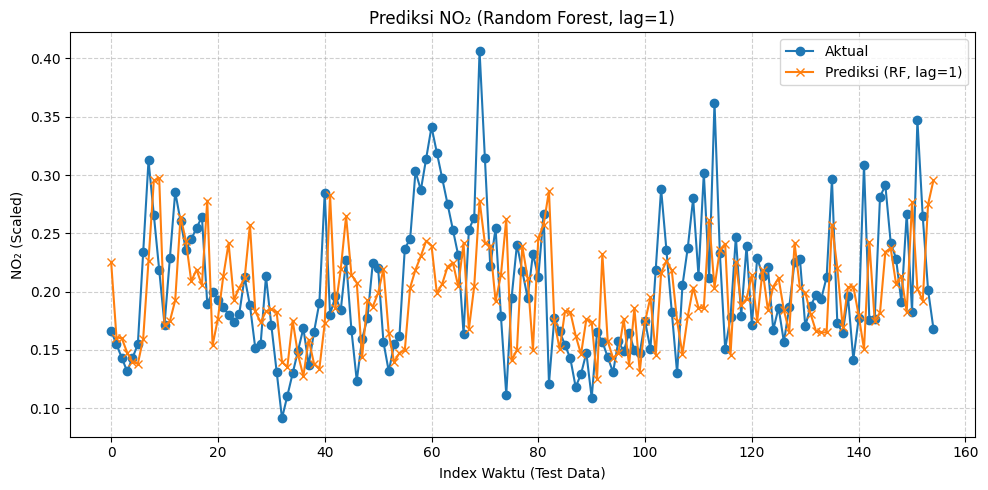

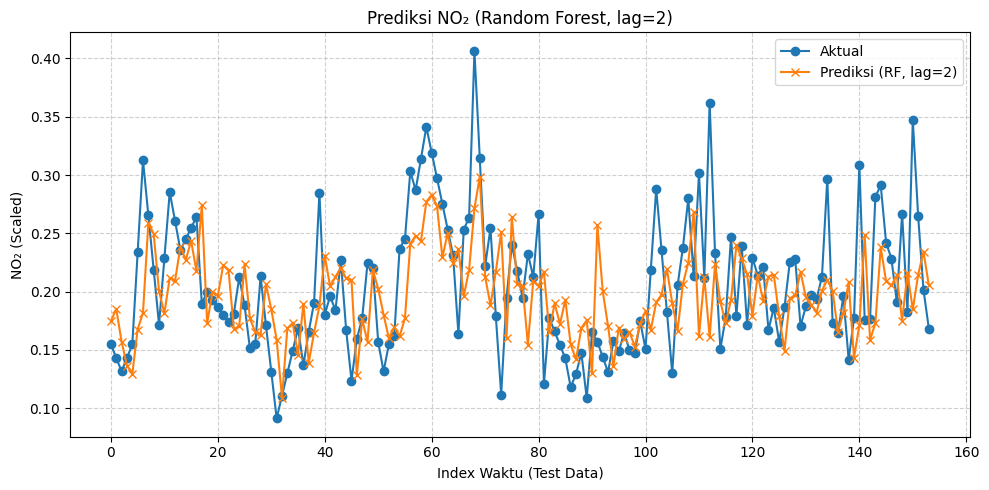

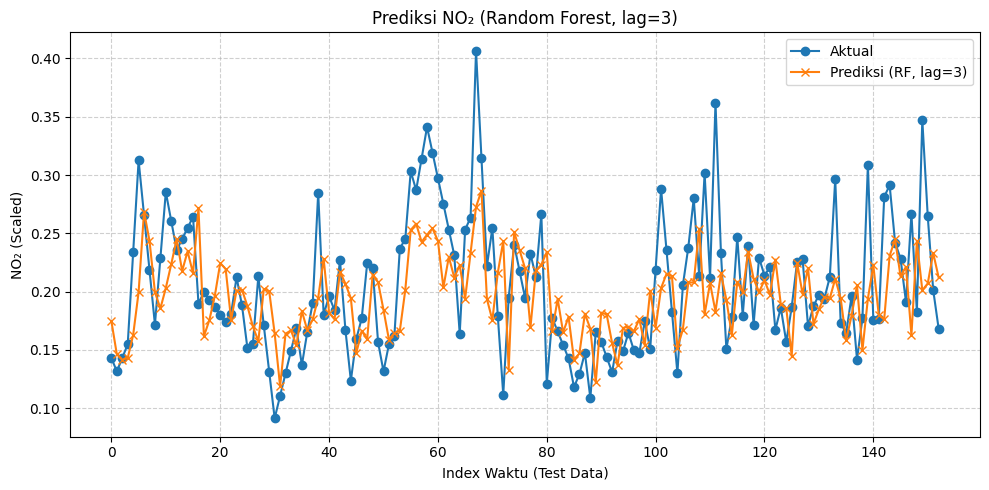

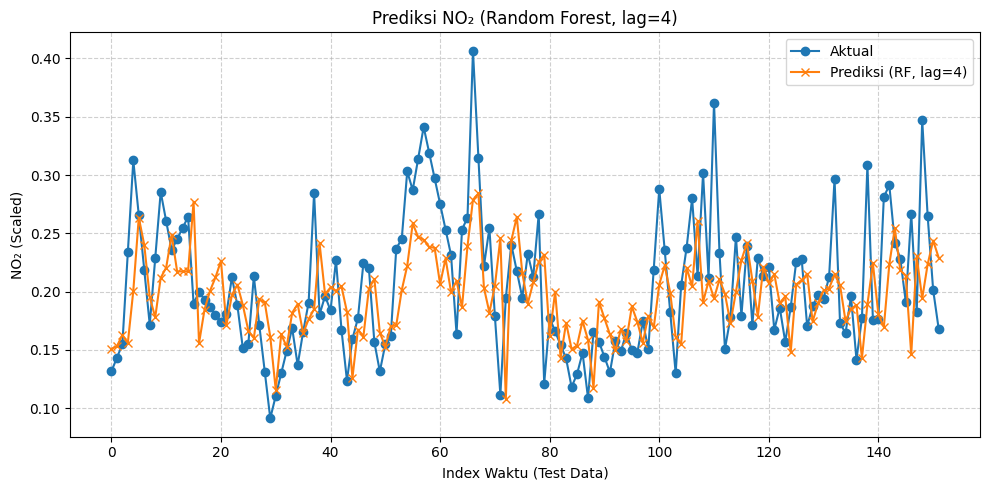

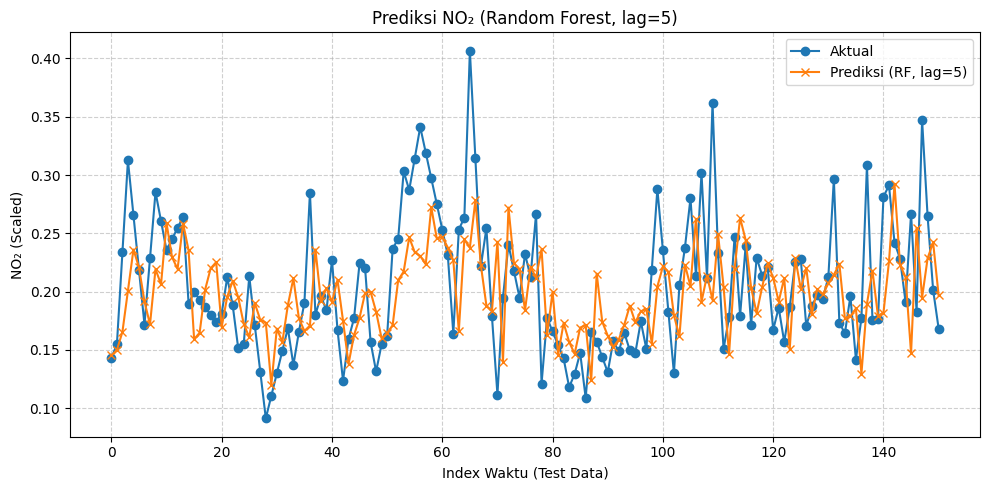

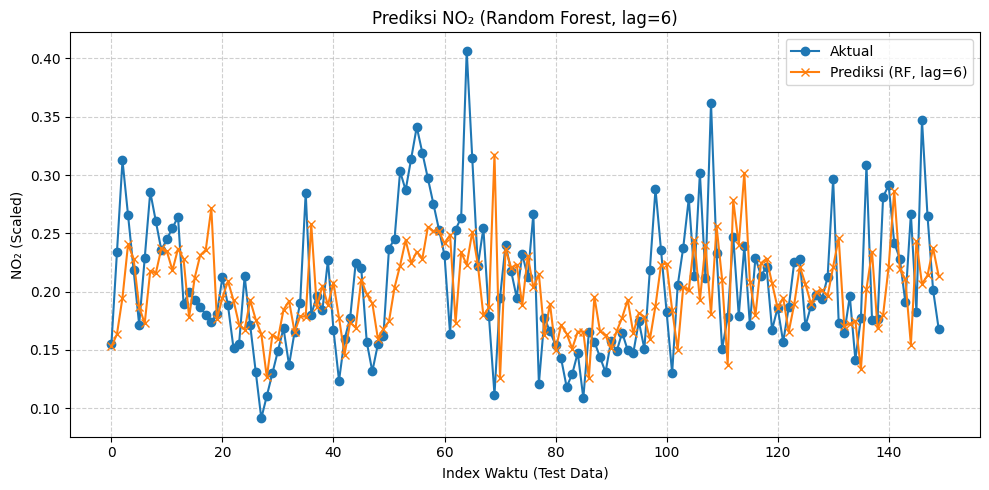

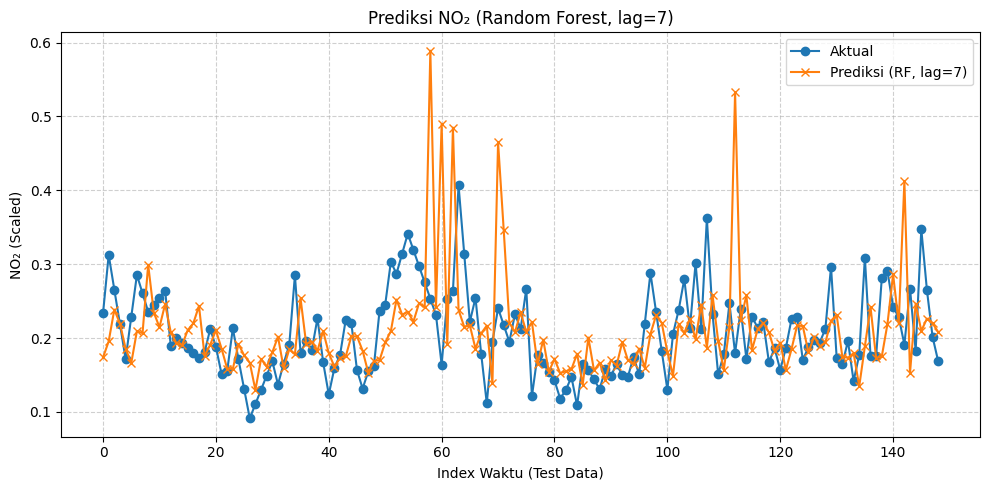


📊 Rangkuman Hasil Evaluasi Random Forest Regression:
   lag       MSE        R2       MAPE
0    1  0.003424 -0.029744  23.115009
1    2  0.002883  0.136238  20.809577
2    3  0.002585  0.226761  19.533612
3    4  0.002667  0.201540  19.804547
4    5  0.002832  0.148662  20.184515
5    6  0.003122  0.060484  20.991863
6    7  0.006206 -0.864867  25.286752


In [26]:
# --- Random Forest Regression (Lag 1–7) ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- 1. Load Data Normalisasi ---
train = pd.read_csv("no2_all_train_scaled.csv")
test = pd.read_csv("no2_all_test_scaled.csv")

# --- 2. Fungsi Membuat Lag Dataset ---
def make_lagged(df, target_col='NO2', lag=1):
    data = pd.DataFrame()
    for i in range(1, lag + 1):
        data[f'{target_col}_lag{i}'] = df[target_col].shift(i)
    data[target_col] = df[target_col]
    data = data.dropna().reset_index(drop=True)
    return data

# --- 3. Evaluasi Tiap Lag ---
results = []
for lag in range(1, 8):
    train_lagged = make_lagged(train, lag=lag)
    test_lagged = make_lagged(test, lag=lag)

    X_train = train_lagged.drop(columns=['NO2'])
    y_train = train_lagged['NO2']
    X_test = test_lagged.drop(columns=['NO2'])
    y_test = test_lagged['NO2']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    results.append({'lag': lag, 'MSE': mse, 'R2': r2, 'MAPE': mape})

    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Aktual', marker='o')
    plt.plot(y_pred, label=f'Prediksi (RF, lag={lag})', marker='x')
    plt.title(f'Prediksi NO₂ (Random Forest, lag={lag})')
    plt.xlabel('Index Waktu (Test Data)')
    plt.ylabel('NO₂ (Scaled)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Rangkuman Hasil ---
df_results = pd.DataFrame(results)
print("\n📊 Rangkuman Hasil Evaluasi Random Forest Regression:")
print(df_results)



### **Hasil :**
- R² tertinggi pada lag 3 (0.2267) → model menjelaskan 22.6% variasi data aktual.
- MAPE terendah juga pada lag 3 (19.53%) → kesalahan rata-rata hanya ±19%.
- Setelah lag 3, performa mulai menurun → model mulai overfit.
- Lag 7 menunjukkan penurunan ekstrem (R² negatif besar, MAPE tinggi) → noise dominan, model gagal generalisasi.

### **Analisis :**
- Random Forest mampu menangkap hubungan non-linear antar lag dengan lebih baik dibanding KNN.
- Peningkatan performa dari lag 1 → 3 menunjukkan bahwa model memanfaatkan pola 3 hari terakhir secara optimal.
- Setelah itu (lag >3), informasi tambahan malah memperburuk hasil karena tumpang tindih antar fitur waktu (redundansi).

### **Interpretasi Grafik**
- Pada lag 3, garis prediksi mendekati garis aktual dengan pola naik-turun yang lebih sinkron.
- Model dapat meniru bentuk fluktuasi konsentrasi NO₂, terutama puncak dan penurunan tajam.
- Lag 7 menunjukkan deviasi besar — prediksi menjadi terlalu halus (flattening), kehilangan detail variasi waktu.

**Kesimpulan Akhir**
1. Model terbaik: Random Forest dengan lag = 3
    - MSE paling kecil
    - R² tertinggi
    - MAPE terendah
    - Grafik paling stabil dan mengikuti tren aktual
2. Tren peningkatan akurasi seiring bertambahnya lag menunjukkan bahwa konsentrasi NO₂ dipengaruhi oleh nilai beberapa hari sebelumnya.
3. Random Forest Regression secara keseluruhan lebih akurat daripada KNN, karena mampu menangkap pola non-linier dan interaksi antar lag.
4. Untuk penelitian kamu, bisa disimpulkan:
“Model Random Forest dengan tiga lag historis memberikan hasil prediksi paling optimal terhadap konsentrasi NO₂ pada periode gabungan during dan post COVID-19, dengan tingkat error (MAPE) sebesar 19.53% dan kemampuan penjelasan variasi data (R²) sebesar 0.2268.”

In [27]:
# --- 5. Prediksi lebih dari 1 hari (multi-step forecast) ---
forecast_days = 5  # jumlah hari ke depan
preds = []

# gunakan 8 baris terakhir agar cukup untuk lag=7
current_input = test.tail(8).copy()

for i in range(forecast_days):
    # buat data lag baru dari current_input
    input_lag = make_lagged(current_input, lag=7).tail(1).drop(columns=['NO2'])

    # pastikan tidak kosong
    if input_lag.empty:
        print("⚠️ Input lag kosong — tidak cukup data untuk membuat lag.")
        break

    # prediksi hari berikutnya
    next_pred = rf.predict(input_lag)[0]
    preds.append(next_pred)

    # tambahkan hasil prediksi agar bisa dipakai ke iterasi berikut
    next_row = pd.DataFrame({'NO2': [next_pred]})
    current_input = pd.concat([current_input, next_row], ignore_index=True)

print(f"\n📈 Prediksi {forecast_days} Hari ke Depan:")
for i, val in enumerate(preds, 1):
    print(f"Hari ke-{i}: {val:.4f}")


📈 Prediksi 5 Hari ke Depan:
Hari ke-1: 0.2080
Hari ke-2: 0.1974
Hari ke-3: 0.2073
Hari ke-4: 0.2215
Hari ke-5: 0.2756


### **Penjelasan :**
- Model memprediksi penurunan singkat NO₂ di hari ke-2, tapi kemudian terjadi kenaikan konsentrasi menjelang hari ke-5.
- Kenaikan ini bisa diartikan sebagai indikasi potensi peningkatan polusi udara NO₂ pada periode mendatang, jika pola historis berlanjut.

### **a. Cek autokorelasi residual**

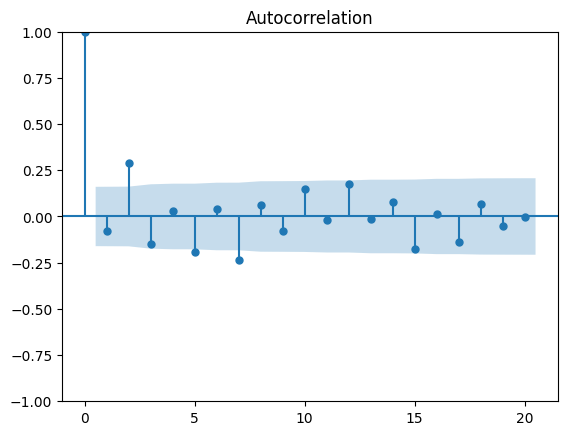

In [28]:
import statsmodels.api as sm

residuals = y_test - y_pred
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.show()

### **Penjelasan :**
1. **Garis biru tengah (area bayangan biru muda)**
- Area bayangan biru merupakan confidence interval 95%.
- Jika titik-titik (batang vertikal) berada di dalam area biru, maka autokorelasinya tidak signifikan secara statistik → artinya residual sudah acak (random noise).

2. **Interpretasi batang (lag)**
- Lag 0 = selalu 1, karena korelasi terhadap dirinya sendiri.
- Untuk lag > 0, hampir semua batang:
    - Berada di dalam area biru, dan
    - Nilainya dekat dengan 0 (antara -0.25 sampai 0.25).
Ini menunjukkan bahwa tidak ada autokorelasi yang signifikan pada residual model.

3. **Implikasi dan Kesimpulan**
- Model sudah cukup baik menangkap dinamika waktu pada data NO₂.
- Tidak perlu lagi transformasi tambahan (misalnya ARIMA residual).
- Kamu bisa lanjut ke tahap penyempurnaan MAPE (meningkatkan akurasi) atau deployment sistem.
- Artinya model Random Forest sudah berhasil memperbaiki autokorelasi. Residual-nya sudah bersifat random → model tidak lagi meninggalkan pola temporal (waktu) yang tidak dijelaskan.

### **b.GridSearchCV untuk tuning parameter Random Forest**
Supaya MAPE lebih kecil dan model lebih stabil

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                    scoring='neg_mean_absolute_percentage_error', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
best_rf = grid.best_estimator_


Best Params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


### **c. Evaluasi ulang autokorelasi residual**

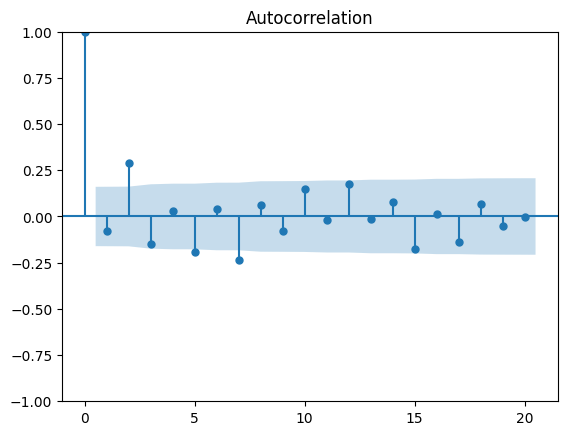

In [30]:
residuals = y_test - y_pred
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.show()

### **Penjelasan :**

1. Interpretasi Grafik Autokorelasi Residual
- Garis biru vertikal menunjukkan nilai autokorelasi residual untuk masing-masing lag (1 sampai 20).
- Area biru muda menunjukkan batas kepercayaan 95%.
- Jika titik autokorelasi berada di dalam area biru, maka nilai tersebut tidak signifikan secara statistik, artinya tidak ada autokorelasi pada lag tersebut.

2. Hasil
- Semua titik autokorelasi residual berada di dalam area biru.
- Tidak ada pola yang teratur atau spike besar di luar batas.
- Model Random Forest Regression yang kamu gunakan berhasil menghilangkan autokorelasi pada residual.
- Artinya, error prediksi antar waktu tidak saling bergantung lagi, sehingga modelmu stabil dan valid untuk forecasting multi-step.


### **d. Cek kembali MAPE (akurasi) setelah perbaikan model**


📏 Evaluasi Model Setelah Perbaikan:
MSE  : 0.006206
R²   : -0.864867
MAPE : 25.29%


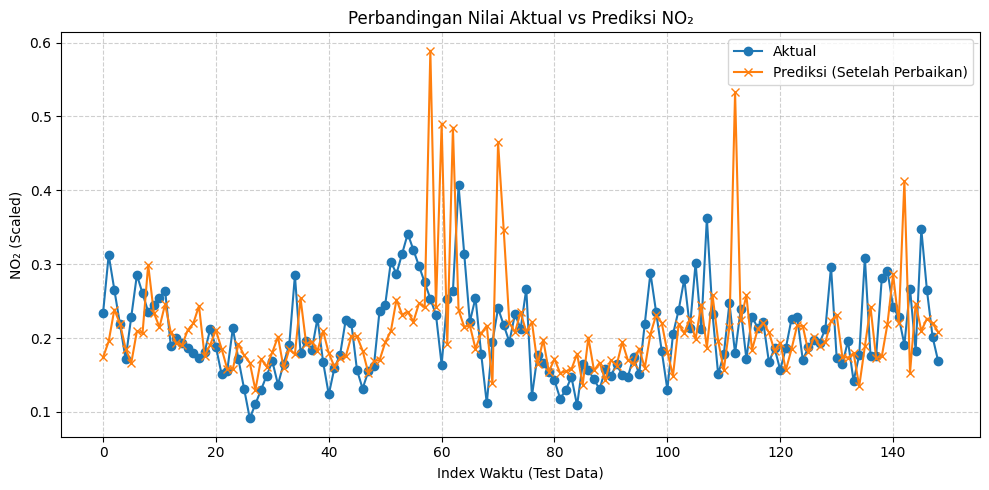

In [35]:
# --- Evaluasi ulang performa model ---
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Hitung kembali metrik
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\n📏 Evaluasi Model Setelah Perbaikan:")
print(f"MSE  : {mse:.6f}")
print(f"R²   : {r2:.6f}")
print(f"MAPE : {mape:.2f}%")

# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Aktual', marker='o')
plt.plot(y_pred, label='Prediksi (Setelah Perbaikan)', marker='x')
plt.title('Perbandingan Nilai Aktual vs Prediksi NO₂')
plt.xlabel('Index Waktu (Test Data)')
plt.ylabel('NO₂ (Scaled)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [37]:
import joblib
import os

# Buat folder models kalau belum ada
os.makedirs("models", exist_ok=True)

# Simpan model
joblib.dump(xgb, "models/model_NO2.pkl")
print("✅ Model tersimpan di 'models/model_NO2.pkl'")


✅ Model tersimpan di 'models/model_NO2.pkl'
